In [9]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections

In [11]:
pd.set_option('display.max_colwidth', 10)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 20000)

In [12]:
import requests

# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download: 100%|██████████████| 78.8M/78.8M [00:40<00:00, 3.08MiB/s]

In [13]:
import zipfile

with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [14]:
interactions = pd.read_csv('data_kion/interactions_df.csv')

In [16]:
# предобработка данных
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


In [17]:
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()
print(min_date, max_date)

2021-03-13 2021-08-22


Выберем данные за 2 недели

In [18]:
interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]['user_id'].nunique()

279129

In [19]:
week1_2 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]
week1_2 = week1_2.groupby('user_id', as_index=False).agg({'total_dur': sum})

/var/folders/gl/5pj9bz2n0254668sft_jrn580000gn/T/ipykernel_61881/1153229452.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  week1_2 = week1_2.groupby('user_id', as_index=False).agg({'total_dur': sum})


In [20]:
week1_2

,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,33776
3,1000001,52
4,1000003,625
...,...,...
279124,999978,29615
279125,999987,27888
279126,999989,4563
279127,999990,997


In [21]:
print(week1_2.shape)
week1_2 = week1_2[(week1_2['total_dur'] < week1_2['total_dur'].std() * 3)]
print(week1_2.shape)

(279129, 2)
(275616, 2)


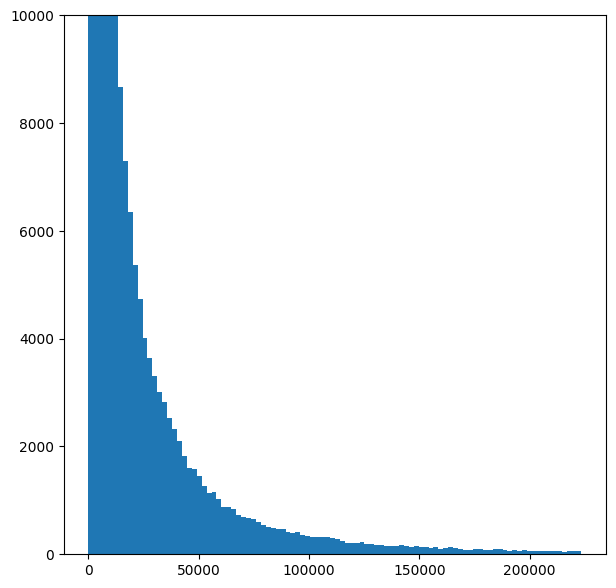

In [22]:
week1_2['total_dur'].hist(bins=100, figsize=(7,7))
plt.ylim([0, 10000])
plt.grid(False)

In [23]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

In [24]:
def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

In [25]:
def groups_splitter(df, columns, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

Посчитаем корректность на бутстрепе для 2 недель

In [17]:
correctness = []
values = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций

    new_df = groups_splitter(week1_2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    correctness.append(not left_side <= 0 <= right_side)

    test_correctness = collections.Counter(correctness)

print(f'significance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')


100%|██████████| 1000/1000 [2:37:22<00:00,  9.44s/it]

significance: 4.3999999999999995%


корректность была 5%, стала 4.4%

далее я забыл исправить в принте significance на power

Мощность для увеличения на 1%

In [27]:
power_1 = []
values = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций

    new_df = groups_splitter(week1_2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur'] * 1.01

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power_1.append(not left_side <= 0 <= right_side)

    test_power_1 = collections.Counter(power_1)

print(f'significance: {test_power_1[1]/(test_power_1[1] + test_power_1[0])*100}%')


100%|█████████████████████████████████████| 1000/1000 [1:16:38<00:00,  4.60s/it]

significance: 33.5%


Мощность для увеличения на 3%

In [28]:
power_3 = []
values_3 = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций

    new_df = groups_splitter(week1_2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur'] * 1.03

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values_3.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power_3.append(not left_side <= 0 <= right_side)

    test_power_3 = collections.Counter(power_3)

print(f'significance: {test_power_3[1]/(test_power_3[1] + test_power_3[0])*100}%')


100%|█████████████████████████████████████| 1000/1000 [1:22:59<00:00,  4.98s/it]

significance: 99.4%


In [29]:
power_5 = []
values_5 = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций

    new_df = groups_splitter(week1_2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur'] * 1.05

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values_5.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power_5.append(not left_side <= 0 <= right_side)

    test_power_5 = collections.Counter(power_5)

print(f'significance: {test_power_5[1]/(test_power_5[1] + test_power_5[0])*100}%')


100%|█████████████████████████████████████| 1000/1000 [1:16:38<00:00,  4.60s/it]

significance: 100.0%


далее посчитаем mde

для этого возьмем alpha = 0.044 и beta = 0.006, как в 3%

In [32]:
from scipy.stats import norm

In [33]:
def get_mde(metric_vec, alpha=0.05, beta=0.2):
    
    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()
    
    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)
    
    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    
    return mde*100/metric_mean

In [34]:
get_mde(week1_2.copy()['total_dur'], alpha=0.044, beta=0.006)

1.5061790866604148

получили mde 1.5%

In [37]:
week1_2['total_dur'] = week1_2['total_dur'].apply(lambda x: 0 if x < 500 else x)

/var/folders/gl/5pj9bz2n0254668sft_jrn580000gn/T/ipykernel_61881/59428898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week1_2['total_dur'] = week1_2['total_dur'].apply(lambda x: 0 if x < 500 else x)


In [40]:
new_df = groups_splitter(week1_2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt='kiontestmodel20210805')

In [41]:
new_df

,user_id,total_dur,group
0,1,21172,B
1,1000,10744,B
2,1000000,33776,B
3,1000001,0,B
4,1000003,625,A
...,...,...,...
279124,999978,29615,A
279125,999987,27888,A
279126,999989,4563,B
279127,999990,997,B


In [47]:
np.percentile(new_df[new_df['group'] == 'B']['total_dur'], 90)

44010.0

In [50]:
len(new_df[new_df['group'] == 'B'])

137196

In [49]:
len(new_df[new_df['group'] == 'B'][new_df[new_df['group'] == 'B']['total_dur'] > 44010])

13719

In [51]:
def apply_changes(col1, col2):
    res = []
    for i in range(len(col1)):
        if col1[i] == 'A':
            res.append(col2[i])
        else:
            if col2[i] > 44010:
                res.append(col2[i] * 1.025)
            else:
                res.append(col2[i])
    return res

new_df['new_metric'] = apply_changes(new_df['group'].values, new_df['total_dur'].values)

проверим уровень значимости изменений бутстрапом

In [59]:
correctness = []
values = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций

    vec_a = new_df[(new_df['group'] == 'A')]['new_metric'].copy()
    vec_b = new_df[(new_df['group'] == 'B')]['new_metric'].copy()

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_b_mean - sample_a_mean)

    left_side, right_side = np.percentile(sample_b_mean - sample_a_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    correctness.append(not left_side >= 0)

    test_correctness = collections.Counter(correctness)
    
    if i % 73 == 0:
        print(f'significance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

print(f'significance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')


100%|█████████████████████████████████████| 1000/1000 [1:08:52<00:00,  4.13s/it]

significance: 2.9000000000000004%


Поскольку мы проверяли только то, что в группе B среднее выше, можем сделать вывод, что это правда, вероятность ошибки 2.9%

In [61]:
new_df[(new_df['group'] == 'A')]['new_metric'].mean()

16191.279266002022

In [62]:
new_df[(new_df['group'] == 'B')]['new_metric'].mean()

16422.020439735854

In [63]:
new_df[(new_df['group'] == 'B')]['new_metric'].mean() / new_df[(new_df['group'] == 'A')]['new_metric'].mean()

1.0142509538587439